In [19]:
%matplotlib inline
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.distributions as tdist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML
import time
from PIL import Image
import torch.nn.functional as F

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Initialize some global variables

In [20]:
# Root directory for dataset
dataroot = "TrainImageGrouped_resized"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32#64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

#number of training classes
num_classes = 43

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

print ('...')

...


# DCGAN training

Load the training data set. There are 43 classes, each contain 2000 images.

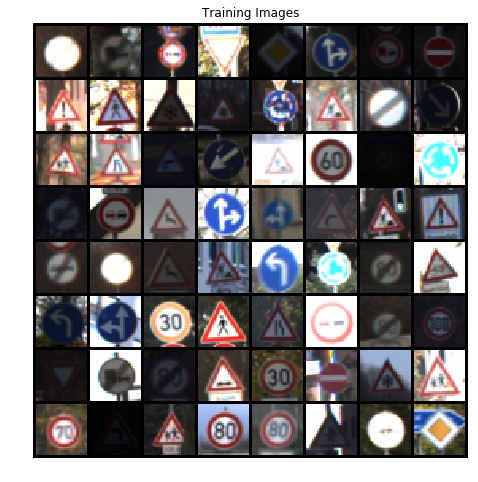

In [21]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [22]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
print ('...')

...


In [23]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [24]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netG.apply(weights_init) # if you want to train by your self, run this

#if you want load trained weights, run this:
netG.load_state_dict(torch.load('./weights/netG_20_epochs.pth', map_location='cpu'))

netG.eval()

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [25]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [26]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netD.apply(weights_init) # if you want to train by your self, run this

#To restore:
#if you want load trained weights, run this:
netD.load_state_dict(torch.load('./weights/netD_20_epochs.pth', map_location='cpu'))
netD.eval()
# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [21]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(image_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
print ("...")

...


## Training Process 
If you want to use the provided weights, just ignore this cell and the next two cells

In [10]:

start_time = time.time()

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

#soft label + flipped label
labelDist2 = tdist.Normal(torch.tensor([1.0]), torch.tensor([0.1]))
labelDist1 = tdist.Normal(torch.tensor([0.1]), torch.tensor([0.1]))

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):        
        random.seed(a=None, version=2)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = labelDist1.sample((b_size,))   #torch.full((b_size,), real_label, device=device)
#         idx = random.sample(range(0, b_size), 5)
#         for i in idx:
#             label[i] = 0
            
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label = labelDist2.sample((b_size,)) #torch.FloatTensor(b_size, ).uniform_(0.0, 0.1) 
#         idx = random.sample(range(0, b_size), 5)
#         for i in idx:
#             label[i] = 1
            
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = labelDist1.sample((b_size,)) # label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats                    
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        #save some output of generator
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
#             plt.figure(figsize=(15,15))
#             plt.imshow(np.transpose(img_list[-1], (1,2,0)))
#             plt.show()
        iters += 1

    print("--- %s seconds ---" % (time.time() - start_time))
    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i+1, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Training Loop...


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([86, 1])) that is different to the input size (torch.Size([86])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


--- 151.07895922660828 seconds ---
[1/1][99/99]	Loss_D: 1.1811	Loss_G: 1.8156	D(x): 0.4083	D(G(z)): 0.6512 / 0.8286


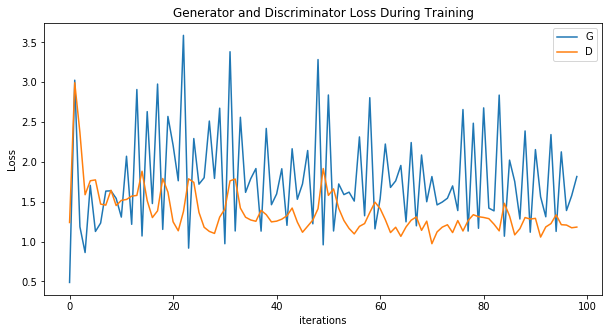

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

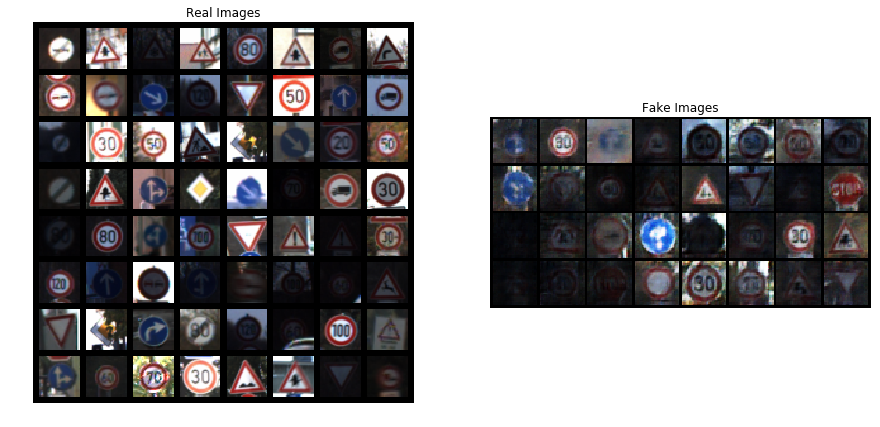

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()

# Traffic Sign Classifier

In [27]:
#train traffic sign classifier 
classes = set()
for i in range(43):
    classes.add(i)

classes = tuple(classes)

trainingClassifierRoot = 'TrainImageGrouped_resized'
testClassifierRoot = 'TestImages'

# Create the dataset
trainClassifierDataset = dset.ImageFolder(root=trainingClassifierRoot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

testClassifierDataset = dset.ImageFolder(root=testClassifierRoot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
trainClassifierLoader = torch.utils.data.DataLoader(trainClassifierDataset, batch_size=batch_size, shuffle=True, num_workers=workers)
testClassifierLoader = torch.utils.data.DataLoader(testClassifierDataset, batch_size=batch_size, shuffle=True, num_workers=workers)
print ('...')

...


In [28]:
class TrafficSignClassifier(nn.Module):
    def __init__(self, ngpu):
        super(TrafficSignClassifier, self).__init__()
        self.ngpu = ngpu
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=0.2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=0.2)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.drop3 = nn.Dropout(p=0.2)        
        
        self.fc = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.relu2(output)
        
        output = self.pool1(output)
        output = self.drop1(output)

        output = self.conv3(output)
        output = self.relu3(output)
        output = self.conv4(output)
        output = self.relu4(output)
        
        output = self.pool2(output)
        output = self.drop2(output)       
        
        output = self.conv5(output)
        output = self.relu5(output)
        output = self.conv6(output)
        output = self.relu6(output)        

        output = self.pool3(output)
        output = self.drop3(output)      
        
        output = output.view(-1, 4 * 4 * 128)
        output = self.fc(output)

        return output

In [29]:
classfier = TrafficSignClassifier(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    classfier = nn.DataParallel(classfier, list(range(ngpu)))
    
#To load the trained weights 
classfier.load_state_dict(torch.load('./weights/CNN.pth', map_location='cpu'))
classfier.eval()
#Print the model
print(classfier)

TrafficSignClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu6): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.2)
  (fc): Linear(in_features=2048, out_features=43, bias=True)
)


In [35]:
#training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classfier.parameters(), lr=0.002, momentum=0.9)

## Training Loop
no need to run if you already loaded the weights



In [36]:
# Training Loop, no need to run if you already loaded the weights
start_time = time.time()
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainClassifierLoader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = classfier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainClassifierLoader:
            images, labels = data
            outputs = classfier(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if total > 10000:
                break

    print('Epoch %d: Accuracy of the network on the 10000 test images: %d %%' % (epoch, 100 * correct / total))
    print("--- %s seconds ---" % (time.time() - start_time))
print('Finished Training')
#torch.save(model.state_dict(), './classifier.pth')

Process Process-64:
Process Process-63:
Process Process-62:
Process Process-61:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  Fi

KeyboardInterrupt: 

## Test Accuracy
Test the accuracy of our traffic sign classifier. The test set consists of 10000+ images. 

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testClassifierLoader:
        images, labels = data
        outputs = classfier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 89 %


## Image Inpainting


Randomly remove certain percent of pixels

In [30]:
def random_mask_generator(height, width, mask_percent):
    mask = np.zeros(height*width, dtype=int)
    num_true=int(mask_percent* height* width)
    mask[:num_true]=1
    np.random.shuffle(mask)
    mask = mask.reshape((height,width))
    mask = mask.astype(float)
    #print(mask.shape())
    return mask

Remove a square from image

In [ ]:
def image_pixel_removing(losing_percent,image_path,filename):
    im=Image.open(image_path)
    pix = im.load()
    width=im.size[0]
    height=im.size[1]
    x_center=width/2
    y_center=height/2
    x_off=width*losing_percent/2
    y_off=height*losing_percent/2
    global flag
    if flag:
        print('width',width)
        print('height',height)
        print('x:',int(x_center-x_off),int(x_center+x_off))
        print('y:',int(y_center-y_off),int(y_center+y_off))
        flag=0
    for x in range(int(x_center-x_off),int(x_center+x_off)):
        for y in range(int(y_center-y_off),int(y_center+y_off)):
            pix[x,y]=(0,0,0)
    im.save('/Users/wujiaying/Downloads/ECE544_final_project_GAN/AllTrafficImageModified/'+filename)

### Load a few images to show the effect 

In [31]:
maskedImageRoot = "singleImg"#"TestImages"#"CroppedImage"
# We can use an image folder dataset the way we have it setup.
# Create the dataset
maskedDataset = dset.ImageFolder(root=maskedImageRoot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
maskedImgLoader = torch.utils.data.DataLoader(maskedDataset, batch_size=batch_size, shuffle=True, num_workers=workers)

You can change the mask types by commemt and uncommemt Line 4 & 5

torch.Size([32, 32])


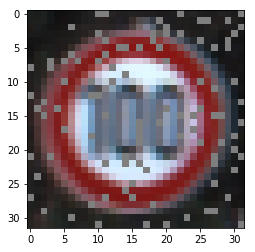

In [16]:
maskedBatch = next(iter(maskedImgLoader))
realImg = maskedBatch[0].to(device)[0] #3*32*32
mask = torch.ones(size=realImg.shape).to(device) 
#mask[:,10:20, 5:15] = 0.0 #remove a square
mask = 1-torch.from_numpy(random_mask_generator(32,32,0.1)).float()# randomly remove pixels 
print (mask.shape)
testImage = torch.mul(realImg, mask)  
npimg = testImage.add(1).div(2).numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
plt.show()

Inpaint and Plot the images, you can change the mask types by commemt and uncomment Line 9 & 10.
You can also change the percentage of area that you want to remove. 

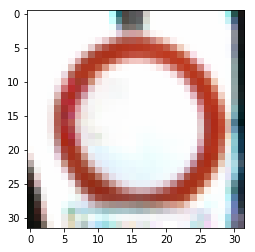

iteration: 0
total loss, context loss, percept loss:  tensor(1434.9641, grad_fn=<ThAddBackward>) tensor(1434.9630, grad_fn=<NormBackward0>) tensor(0.0111, grad_fn=<BinaryCrossEntropyBackward>)


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


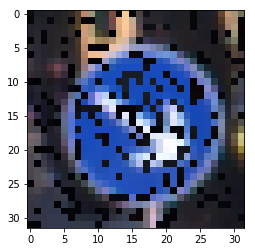

--- 0.25818920135498047 seconds ---
iteration: 1000
total loss, context loss, percept loss:  tensor(342.0941, grad_fn=<ThAddBackward>) tensor(342.0465, grad_fn=<NormBackward0>) tensor(0.4763, grad_fn=<BinaryCrossEntropyBackward>)


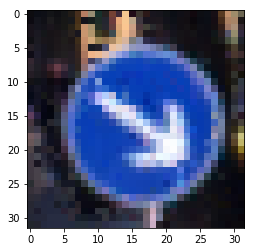

--- 17.278929948806763 seconds ---
iteration: 2000
total loss, context loss, percept loss:  tensor(311.3182, grad_fn=<ThAddBackward>) tensor(311.2681, grad_fn=<NormBackward0>) tensor(0.5007, grad_fn=<BinaryCrossEntropyBackward>)


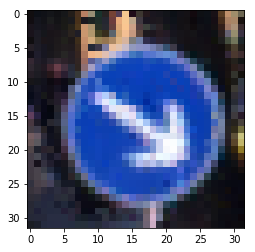

--- 32.734277963638306 seconds ---
iteration: 3000
total loss, context loss, percept loss:  tensor(287.0439, grad_fn=<ThAddBackward>) tensor(286.9935, grad_fn=<NormBackward0>) tensor(0.5040, grad_fn=<BinaryCrossEntropyBackward>)


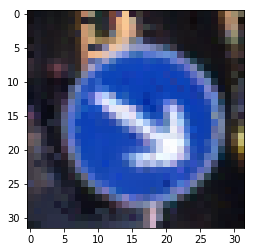

--- 49.88045811653137 seconds ---
iteration: 4000
total loss, context loss, percept loss:  tensor(269.8848, grad_fn=<ThAddBackward>) tensor(269.8416, grad_fn=<NormBackward0>) tensor(0.4328, grad_fn=<BinaryCrossEntropyBackward>)


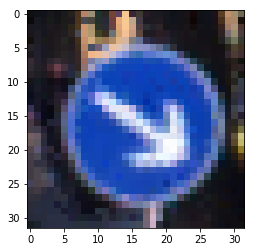

--- 66.11107015609741 seconds ---
iteration: 5000
total loss, context loss, percept loss:  tensor(257.0988, grad_fn=<ThAddBackward>) tensor(257.0552, grad_fn=<NormBackward0>) tensor(0.4361, grad_fn=<BinaryCrossEntropyBackward>)


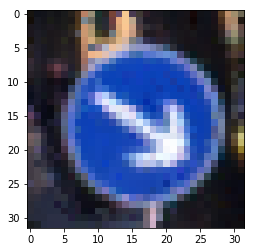

--- 82.1828920841217 seconds ---


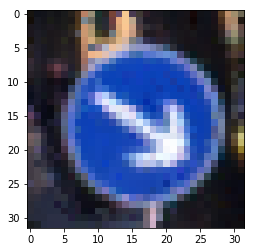

iteration: 0
total loss, context loss, percept loss:  tensor(2229.8367, grad_fn=<ThAddBackward>) tensor(2229.8352, grad_fn=<NormBackward0>) tensor(0.0136, grad_fn=<BinaryCrossEntropyBackward>)


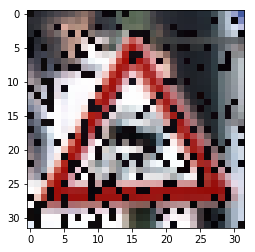

--- 82.48585605621338 seconds ---
iteration: 1000
total loss, context loss, percept loss:  tensor(936.2538, grad_fn=<ThAddBackward>) tensor(936.2532, grad_fn=<NormBackward0>) tensor(0.0070, grad_fn=<BinaryCrossEntropyBackward>)


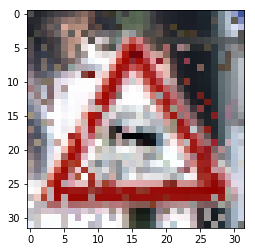

--- 99.16202020645142 seconds ---
iteration: 2000
total loss, context loss, percept loss:  tensor(797.0584, grad_fn=<ThAddBackward>) tensor(797.0579, grad_fn=<NormBackward0>) tensor(0.0056, grad_fn=<BinaryCrossEntropyBackward>)


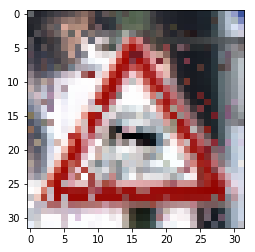

--- 114.9081392288208 seconds ---
iteration: 3000
total loss, context loss, percept loss:  tensor(750.4601, grad_fn=<ThAddBackward>) tensor(750.4593, grad_fn=<NormBackward0>) tensor(0.0081, grad_fn=<BinaryCrossEntropyBackward>)


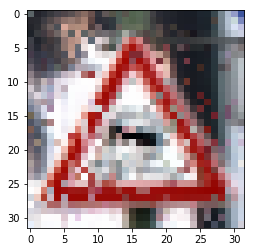

--- 132.07916712760925 seconds ---
iteration: 4000
total loss, context loss, percept loss:  tensor(716.1383, grad_fn=<ThAddBackward>) tensor(716.1372, grad_fn=<NormBackward0>) tensor(0.0111, grad_fn=<BinaryCrossEntropyBackward>)


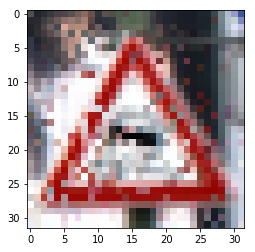

--- 149.00183606147766 seconds ---
iteration: 5000
total loss, context loss, percept loss:  tensor(662.9293, grad_fn=<ThAddBackward>) tensor(662.9284, grad_fn=<NormBackward0>) tensor(0.0088, grad_fn=<BinaryCrossEntropyBackward>)


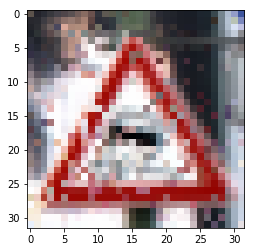

--- 165.09194922447205 seconds ---


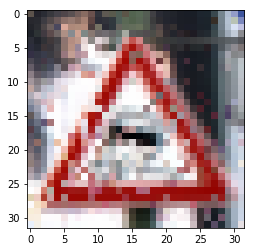

iteration: 0
total loss, context loss, percept loss:  tensor(1164.1217, grad_fn=<ThAddBackward>) tensor(1164.1215, grad_fn=<NormBackward0>) tensor(0.0021, grad_fn=<BinaryCrossEntropyBackward>)


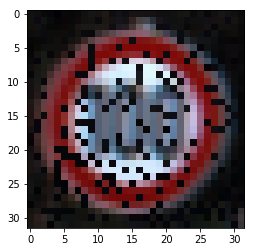

--- 165.27057003974915 seconds ---
iteration: 1000
total loss, context loss, percept loss:  tensor(301.2325, grad_fn=<ThAddBackward>) tensor(301.2276, grad_fn=<NormBackward0>) tensor(0.0487, grad_fn=<BinaryCrossEntropyBackward>)


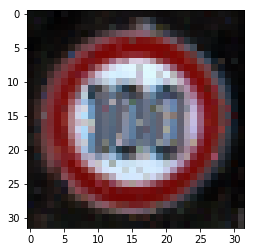

--- 181.54193997383118 seconds ---
iteration: 2000
total loss, context loss, percept loss:  tensor(265.7394, grad_fn=<ThAddBackward>) tensor(265.7341, grad_fn=<NormBackward0>) tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward>)


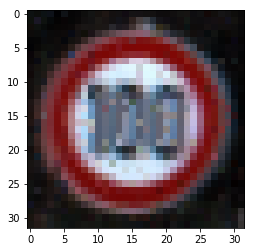

--- 197.73106598854065 seconds ---
iteration: 3000
total loss, context loss, percept loss:  tensor(252.3994, grad_fn=<ThAddBackward>) tensor(252.3942, grad_fn=<NormBackward0>) tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward>)


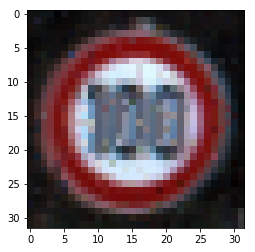

--- 213.8382420539856 seconds ---
iteration: 4000
total loss, context loss, percept loss:  tensor(245.5746, grad_fn=<ThAddBackward>) tensor(245.5697, grad_fn=<NormBackward0>) tensor(0.0489, grad_fn=<BinaryCrossEntropyBackward>)


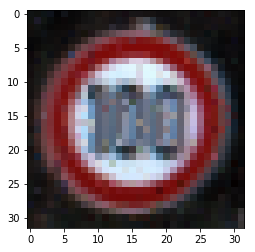

--- 230.09684705734253 seconds ---
iteration: 5000
total loss, context loss, percept loss:  tensor(243.2566, grad_fn=<ThAddBackward>) tensor(243.2518, grad_fn=<NormBackward0>) tensor(0.0484, grad_fn=<BinaryCrossEntropyBackward>)


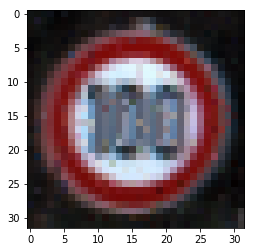

--- 246.12303590774536 seconds ---


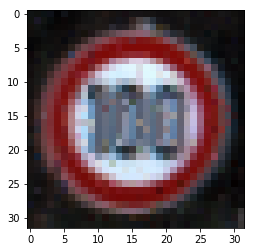

iteration: 0
total loss, context loss, percept loss:  tensor(2663.2578, grad_fn=<ThAddBackward>) tensor(2663.2578, grad_fn=<NormBackward0>) tensor(0.0001, grad_fn=<BinaryCrossEntropyBackward>)


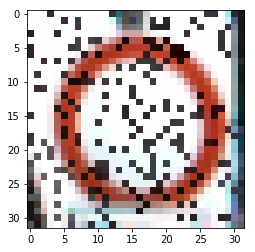

--- 246.3300712108612 seconds ---
iteration: 1000
total loss, context loss, percept loss:  tensor(402.9101, grad_fn=<ThAddBackward>) tensor(402.7873, grad_fn=<NormBackward0>) tensor(1.2277, grad_fn=<BinaryCrossEntropyBackward>)


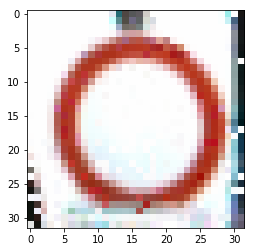

--- 262.68889808654785 seconds ---
iteration: 2000
total loss, context loss, percept loss:  tensor(373.6943, grad_fn=<ThAddBackward>) tensor(373.5681, grad_fn=<NormBackward0>) tensor(1.2622, grad_fn=<BinaryCrossEntropyBackward>)


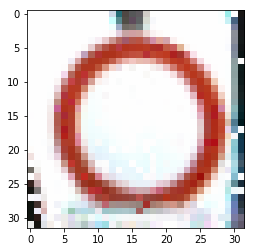

--- 278.81402611732483 seconds ---
iteration: 3000
total loss, context loss, percept loss:  tensor(359.8105, grad_fn=<ThAddBackward>) tensor(359.6874, grad_fn=<NormBackward0>) tensor(1.2314, grad_fn=<BinaryCrossEntropyBackward>)


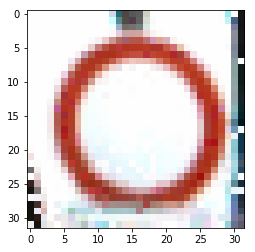

--- 297.4892029762268 seconds ---
iteration: 4000
total loss, context loss, percept loss:  tensor(195.7342, grad_fn=<ThAddBackward>) tensor(195.6085, grad_fn=<NormBackward0>) tensor(1.2573, grad_fn=<BinaryCrossEntropyBackward>)


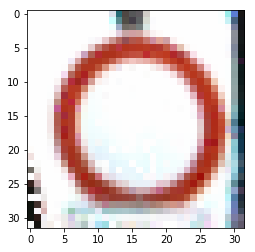

--- 314.8690719604492 seconds ---
iteration: 5000
total loss, context loss, percept loss:  tensor(184.6438, grad_fn=<ThAddBackward>) tensor(184.5173, grad_fn=<NormBackward0>) tensor(1.2652, grad_fn=<BinaryCrossEntropyBackward>)


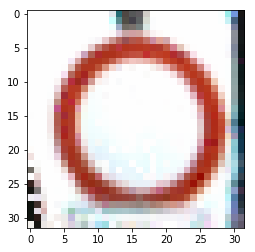

--- 330.9872760772705 seconds ---


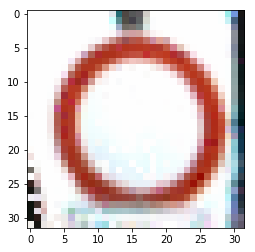

iteration: 0
total loss, context loss, percept loss:  tensor(1909.0009, grad_fn=<ThAddBackward>) tensor(1908.9994, grad_fn=<NormBackward0>) tensor(0.0145, grad_fn=<BinaryCrossEntropyBackward>)


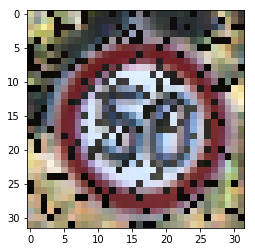

--- 331.1640000343323 seconds ---
iteration: 1000
total loss, context loss, percept loss:  tensor(506.1844, grad_fn=<ThAddBackward>) tensor(506.0939, grad_fn=<NormBackward0>) tensor(0.9048, grad_fn=<BinaryCrossEntropyBackward>)


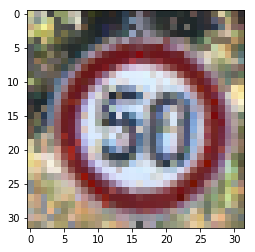

--- 347.56591391563416 seconds ---
iteration: 2000
total loss, context loss, percept loss:  tensor(454.2464, grad_fn=<ThAddBackward>) tensor(454.1396, grad_fn=<NormBackward0>) tensor(1.0675, grad_fn=<BinaryCrossEntropyBackward>)


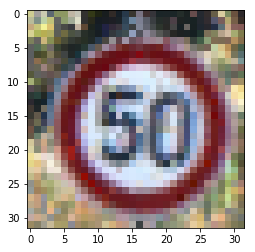

--- 365.55342507362366 seconds ---
iteration: 3000
total loss, context loss, percept loss:  tensor(428.2771, grad_fn=<ThAddBackward>) tensor(428.1690, grad_fn=<NormBackward0>) tensor(1.0802, grad_fn=<BinaryCrossEntropyBackward>)


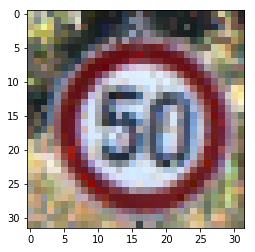

--- 381.56800413131714 seconds ---
iteration: 4000
total loss, context loss, percept loss:  tensor(414.5049, grad_fn=<ThAddBackward>) tensor(414.3926, grad_fn=<NormBackward0>) tensor(1.1223, grad_fn=<BinaryCrossEntropyBackward>)


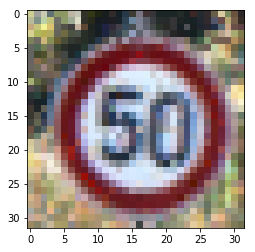

--- 398.3775050640106 seconds ---
iteration: 5000
total loss, context loss, percept loss:  tensor(405.7717, grad_fn=<ThAddBackward>) tensor(405.6627, grad_fn=<NormBackward0>) tensor(1.0901, grad_fn=<BinaryCrossEntropyBackward>)


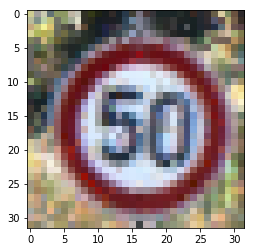

--- 415.2017471790314 seconds ---


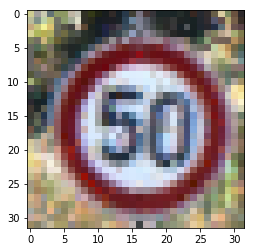

iteration: 0
total loss, context loss, percept loss:  tensor(1623.5576, grad_fn=<ThAddBackward>) tensor(1623.5566, grad_fn=<NormBackward0>) tensor(0.0102, grad_fn=<BinaryCrossEntropyBackward>)


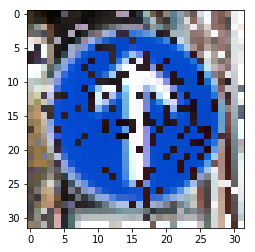

--- 415.40633726119995 seconds ---
iteration: 1000
total loss, context loss, percept loss:  tensor(561.2507, grad_fn=<ThAddBackward>) tensor(560.9791, grad_fn=<NormBackward0>) tensor(2.7160, grad_fn=<BinaryCrossEntropyBackward>)


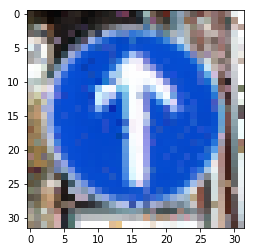

--- 432.27859902381897 seconds ---
iteration: 2000
total loss, context loss, percept loss:  tensor(513.0352, grad_fn=<ThAddBackward>) tensor(512.7628, grad_fn=<NormBackward0>) tensor(2.7241, grad_fn=<BinaryCrossEntropyBackward>)


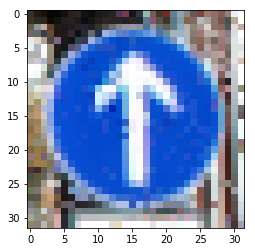

--- 448.1791260242462 seconds ---
iteration: 3000
total loss, context loss, percept loss:  tensor(450.9242, grad_fn=<ThAddBackward>) tensor(450.6574, grad_fn=<NormBackward0>) tensor(2.6680, grad_fn=<BinaryCrossEntropyBackward>)


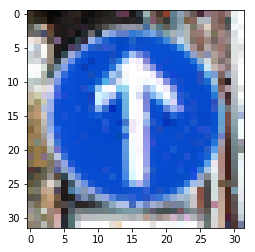

--- 463.95109510421753 seconds ---
iteration: 4000
total loss, context loss, percept loss:  tensor(411.6024, grad_fn=<ThAddBackward>) tensor(411.3163, grad_fn=<NormBackward0>) tensor(2.8617, grad_fn=<BinaryCrossEntropyBackward>)


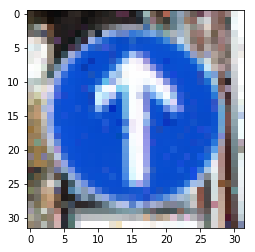

--- 482.2126660346985 seconds ---
iteration: 5000
total loss, context loss, percept loss:  tensor(402.1739, grad_fn=<ThAddBackward>) tensor(401.8865, grad_fn=<NormBackward0>) tensor(2.8738, grad_fn=<BinaryCrossEntropyBackward>)


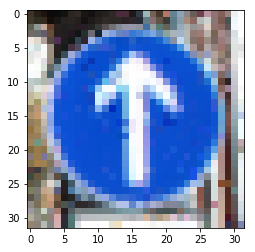

--- 497.77257108688354 seconds ---


In [63]:
lambd = 0.1
croppedPercentage = 0.2
inpaintCriteria = nn.BCELoss()
for i, data in enumerate(maskedImgLoader, 0): 
    start_time = time.time()
    images, labels = data
    for j in range(images.shape[0]):
        realImg = images.to(device)[j]
        mask = torch.ones(size=testImage.shape).to(device) 
        #mask[:,10:20, 5:15] = 0.0 # remove square
        mask = 1-torch.from_numpy(random_mask_generator(32,32,croppedPercentage)).float()#randomly remove 
        croppedImg = torch.mul(realImg, mask)  
        plt.imshow(img)
        plt.show()

        #z = torch.randn(1, nz, 1, 1, device=device)
        z = torch.rand(size=[1,100,1,1],dtype=torch.float32,requires_grad=True,device=device)
        z.data.mul_(2.0).sub_(1.0)
        opt = optim.Adam([z],lr=0.005) 
        for i in range(5001): # you can change the iteration times
            if z.grad is not None:
                z.grad.data.zero_()
            netG.zero_grad()
            netD.zero_grad()

            fake = netG(z)
            fakeMasked = torch.mul(fake[0], mask)
            impaintedImg = torch.mul(fake,(1-mask)) + croppedImg   
            contextLoss = torch.norm((croppedImg-fakeMasked),p=1)
            discOutput = netD(impaintedImg)
            batchLabels = torch.full((1,), 1, device=device)
            perceptLoss = inpaintCriteria(discOutput, batchLabels)

            totalLoss = contextLoss + lambd*perceptLoss
            if i % 1000==0:
                print("iteration:" , i)
                print ("total loss, context loss, percept loss: ", totalLoss, contextLoss, perceptLoss)
                vutils.save_image(impaintedImg, 'impaintImage.png', normalize=True)
                img=mpimg.imread('impaintImage.png')
                plt.imshow(img)
                plt.show()
                print("--- %s seconds ---" % (time.time() - start_time))
            totalLoss.backward()
            #print(z.grad)
            opt.step()

### Run on the large data set(425 images)
The recovered images will be saved in folder ./inpaintingResult

In [32]:
maskedImageRoot = "CroppedImage"
# We can use an image folder dataset the way we have it setup.
# Create the dataset
maskedDataset = dset.ImageFolder(root=maskedImageRoot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
maskedImgLoader = torch.utils.data.DataLoader(maskedDataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [33]:
lambd = 0.1
inpaintCriteria = nn.BCELoss()
mask = torch.ones(size=testImage.shape).to(device)
mask[:,10:20, 5:15] = 0.0
#mask = torch.from_numpy(random_mask_generator(32,32,0.1)).float()
#print (mask)

correctPreComplete = 0
totalPreComplete = 0
correctCompleted = 0
totalCompleted = 0
num_iterations = 5000

#iterative inpainting process
for i, data in enumerate(maskedImgLoader, 0): 
    start_time = time.time()
    images, labels = data
    for j in range(images.shape[0]):
        realImg = images.to(device)[j]
        croppedImg = torch.mul(realImg, mask)  

        #measure accuracy before image inpainting
        outputs = classfier(croppedImg.unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        totalPreComplete += 1
        if (predicted == labels[j]):
            correctPreComplete += 1
    
        #initialize latent vector Z 
        z = torch.rand(size=[1,100,1,1],dtype=torch.float32,requires_grad=True,device=device)
        z.data.mul_(2.0).sub_(1.0)
        opt = optim.Adam([z],lr=0.005) 
        for k in range(num_iterations+1):
            if z.grad is not None:
                z.grad.data.zero_()
            netG.zero_grad()
            netD.zero_grad()

            fake = netG(z)
            fakeMasked = torch.mul(fake[0], mask)
            impaintedImg = torch.mul(fake,(1-mask)) + croppedImg   

            contextLoss = torch.norm((croppedImg-fakeMasked),p=1)
            discOutput = netD(impaintedImg)
            batchLabels = torch.full((1,), 1, device=device)
            perceptLoss = inpaintCriteria(discOutput, batchLabels)
            totalLoss = (1-lambd)*contextLoss + lambd*perceptLoss

            if k == num_iterations:
#                 print("iteration:" , k)
#                 print ("total loss, context loss, percept loss: ", totalLoss, contextLoss, perceptLoss)
                vutils.save_image(impaintedImg, 'inpaintingResult/'+ str(j) +'.png', normalize=True)
#                 img=mpimg.imread('impaintImage.png')
#                 plt.imshow(img)
#                 plt.show()
            totalLoss.backward()
            opt.step()
        
    #measure the accuracy of claasifier after the inpainting
        outputs = classfier(impaintedImg)
        _, predicted = torch.max(outputs.data, 1)
        totalCompleted += 1
        if (predicted == labels[j]):
            correctCompleted += 1
        print("--- %s seconds ---" % (time.time() - start_time))
        print('Accuracy on the test images before inpainting: %d %%' % (100.0 * correctPreComplete / totalPreComplete))
        print('Accuracy on the test images after inpainting: %d %%' % (100.0 * correctCompleted / totalCompleted))
        print (correctPreComplete, totalPreComplete, correctCompleted, totalCompleted)


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


--- 79.89339303970337 seconds ---
Accuracy on the test images before inpainting: 100 %
Accuracy on the test images after inpainting: 0 %
1 1 0 1
--- 160.15426921844482 seconds ---
Accuracy on the test images before inpainting: 50 %
Accuracy on the test images after inpainting: 0 %
1 2 0 2
--- 239.00262904167175 seconds ---
Accuracy on the test images before inpainting: 66 %
Accuracy on the test images after inpainting: 33 %
2 3 1 3
--- 313.8536298274994 seconds ---
Accuracy on the test images before inpainting: 50 %
Accuracy on the test images after inpainting: 25 %
2 4 1 4
--- 387.2621109485626 seconds ---
Accuracy on the test images before inpainting: 60 %
Accuracy on the test images after inpainting: 20 %
3 5 1 5
--- 462.97765922546387 seconds ---
Accuracy on the test images before inpainting: 66 %
Accuracy on the test images after inpainting: 33 %
4 6 2 6
--- 542.103844165802 seconds ---
Accuracy on the test images before inpainting: 71 %
Accuracy on the test images after inpaintin

--- 4571.033248901367 seconds ---
Accuracy on the test images before inpainting: 54 %
Accuracy on the test images after inpainting: 61 %
31 57 35 57
--- 4654.425369024277 seconds ---
Accuracy on the test images before inpainting: 55 %
Accuracy on the test images after inpainting: 62 %
32 58 36 58
--- 4732.484262228012 seconds ---
Accuracy on the test images before inpainting: 54 %
Accuracy on the test images after inpainting: 62 %
32 59 37 59
--- 4809.556680202484 seconds ---
Accuracy on the test images before inpainting: 53 %
Accuracy on the test images after inpainting: 63 %
32 60 38 60
--- 4887.353629112244 seconds ---
Accuracy on the test images before inpainting: 52 %
Accuracy on the test images after inpainting: 63 %
32 61 39 61
--- 4964.094770908356 seconds ---
Accuracy on the test images before inpainting: 51 %
Accuracy on the test images after inpainting: 62 %
32 62 39 62
--- 5040.4369032382965 seconds ---
Accuracy on the test images before inpainting: 50 %
Accuracy on the tes

--- 9128.901998996735 seconds ---
Accuracy on the test images before inpainting: 55 %
Accuracy on the test images after inpainting: 70 %
62 112 79 112
--- 9204.990534067154 seconds ---
Accuracy on the test images before inpainting: 54 %
Accuracy on the test images after inpainting: 69 %
62 113 79 113
--- 9281.348594903946 seconds ---
Accuracy on the test images before inpainting: 54 %
Accuracy on the test images after inpainting: 70 %
62 114 80 114
--- 9357.039017915726 seconds ---
Accuracy on the test images before inpainting: 54 %
Accuracy on the test images after inpainting: 70 %
63 115 81 115
--- 9432.884663105011 seconds ---
Accuracy on the test images before inpainting: 55 %
Accuracy on the test images after inpainting: 70 %
64 116 82 116
--- 9508.573213100433 seconds ---
Accuracy on the test images before inpainting: 55 %
Accuracy on the test images after inpainting: 70 %
65 117 83 117
--- 9584.718902111053 seconds ---
Accuracy on the test images before inpainting: 55 %
Accuracy

--- 2852.1408591270447 seconds ---
Accuracy on the test images before inpainting: 51 %
Accuracy on the test images after inpainting: 69 %
86 166 116 166
--- 2927.507623910904 seconds ---
Accuracy on the test images before inpainting: 51 %
Accuracy on the test images after inpainting: 69 %
86 167 116 167
--- 3003.3113510608673 seconds ---
Accuracy on the test images before inpainting: 51 %
Accuracy on the test images after inpainting: 69 %
86 168 117 168
--- 3079.7271780967712 seconds ---
Accuracy on the test images before inpainting: 50 %
Accuracy on the test images after inpainting: 69 %
86 169 118 169
--- 3156.2439880371094 seconds ---
Accuracy on the test images before inpainting: 51 %
Accuracy on the test images after inpainting: 70 %
87 170 119 170
--- 3232.032662153244 seconds ---
Accuracy on the test images before inpainting: 50 %
Accuracy on the test images after inpainting: 69 %
87 171 119 171
--- 3308.1155750751495 seconds ---
Accuracy on the test images before inpainting: 50

--- 6960.639847993851 seconds ---
Accuracy on the test images before inpainting: 48 %
Accuracy on the test images after inpainting: 69 %
106 220 152 220
--- 7036.289359092712 seconds ---
Accuracy on the test images before inpainting: 48 %
Accuracy on the test images after inpainting: 69 %
107 221 153 221
